# 如何添加动态断点

!!!笔记
对于“人在循环”工作流程，请使用新的 [`interrupt()`(/langgraphjs/reference/functions/langgraph.interrupt-1.html) 函数来实现“人在循环”工作流程。请查看 [Human-in-the-loop 概念指南](/langgraphjs/concepts/ human_in_the_loop)，了解有关 `interrupt` 设计模式的更多信息。

!!!提示“先决条件”
本指南假设您熟悉以下概念：

* [断点](/langgraphjs/concepts/breakpoints)
* [LangGraph 术语表](/langgraphjs/concepts/low_level)

人机回路（HIL）交互对于代理系统至关重要（https://langchain-ai.github.io/langgraphjs/concepts/agentic_concepts/# human-in-the-loop）。[断点](https://langchain-ai.github.io/langgraphjs/concepts/low_level/#breakpoints) 是一种常见的 HIL 交互模式，允许图表在特定步骤处停止并在继续之前寻求人类批准（例如，对于敏感操作）。

在 LangGraph 中，您可以在执行节点之前/之后添加断点。但通常情况下，根据某些条件从给定节点内部**动态**中断图形可能会有所帮助。这样做时，包含有关**为什么**引发中断的信息也可能会有所帮助。

本指南展示了如何使用 `NodeInterrupt` 动态中断图形——一种可以从节点内部引发的特殊异常。让我们看看它的实际效果！

### 定义图表

In [1]:
import {
  Annotation,
  MemorySaver,
  NodeInterrupt,
  StateGraph,
} from "@langchain/langgraph";

const StateAnnotation = Annotation.Root({
  input: Annotation<string>,
});

const step1 = async (state: typeof StateAnnotation.State) => {
  console.log("---Step 1---");
  return state;
};

const step2 = async (state: typeof StateAnnotation.State) => {
  // 让我们选择性地引发一个 NodeInterrupt
  // 如果输入的长度超过5个字符
  if (state.input?.length > 5) {
    throw new NodeInterrupt(`Received input that is longer than 5 characters: ${state.input}`);
  }
  console.log("---Step 2---");
  return state;
};

const step3 = async (state: typeof StateAnnotation.State) => {
  console.log("---Step 3---");
  return state;
};

const checkpointer = new MemorySaver();

const graph = new StateGraph(StateAnnotation)
  .addNode("step1", step1)
  .addNode("step2", step2)
  .addNode("step3", step3)
  .addEdge("__start__", "step1")
  .addEdge("step1", "step2")
  .addEdge("step2", "step3")
  .addEdge("step3", "__end__")
  .compile({ checkpointer });

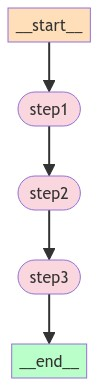

In [2]:
import * as tslab from "tslab";

const representation = graph.getGraph();
const image = await representation.drawMermaidPng();
const arrayBuffer = await image.arrayBuffer();

await tslab.display.png(new Uint8Array(arrayBuffer));

### 使用动态中断运行图表

首先，让我们使用长度 <= 5 个字符的输入来运行图表。这应该安全地忽略我们定义的中断条件，并在图形执行结束时返回原始输入。

In [3]:
const initialInput = { input: "hello" };
const config = {
  configurable: {
    thread_id: "1",
  },
  streamMode: "values" as const,
};

const stream = await graph.stream(initialInput, config);

for await (const event of stream) {
  console.log(event);
}

{ input: 'hello' }
---Step 1---
{ input: 'hello' }
---Step 2---
{ input: 'hello' }
---Step 3---
{ input: 'hello' }


如果我们此时检查图表，我们可以看到没有更多任务需要运行，并且图表确实完成了执行。

In [4]:
const state = await graph.getState(config);
console.log(state.next);
console.log(state.tasks);

[]
[]


现在，让我们使用长度超过 5 个字符的输入来运行该图。这应该触发我们通过在 `step2` 节点内引发 `NodeInterrupt` 错误定义的动态中断。

In [5]:
const longInput = { input: "hello world" };
const config2 = {
  configurable: {
    thread_id: "2",
  },
  streamMode: "values" as const,
};

const streamWithInterrupt = await graph.stream(longInput, config2);

for await (const event of streamWithInterrupt) {
  console.log(event);
}

{ input: 'hello world' }
---Step 1---
{ input: 'hello world' }


我们可以看到图形现在在执行 `step2` 时停止了。如果我们检查此时的图形状态，我们可以看到有关哪个节点被设置为下一步执行的信息（`step2`），以及哪个节点引发了中断（也是`step2`），以及有关中断的其他信息。

In [6]:
const state2 = await graph.getState(config2);
console.log(state2.next);
console.log(JSON.stringify(state2.tasks, null, 2));

[ 'step2' ]
[
  {
    "id": "c91a38f7-2aec-5c38-a3f0-60fba6efe73c",
    "name": "step2",
    "interrupts": [
      {
        "value": "Received input that is longer than 5 characters: hello world",
        "when": "during"
      }
    ]
  }
]


如果我们尝试从断点恢复图形，我们将再次中断，因为我们的输入和图形状态没有改变。

In [7]:
// 注意：要从动态中断中恢复图形，我们使用与
// 常规中断——我们传递 null 作为输入
const resumedStream = await graph.stream(null, config2);

for await (const event of resumedStream) {
  console.log(event);
}

In [8]:
const state3 = await graph.getState(config2);
console.log(state3.next);
console.log(JSON.stringify(state2.tasks, null, 2));

[ 'step2' ]
[
  {
    "id": "c91a38f7-2aec-5c38-a3f0-60fba6efe73c",
    "name": "step2",
    "interrupts": [
      {
        "value": "Received input that is longer than 5 characters: hello world",
        "when": "during"
      }
    ]
  }
]


### 更新图状态

为了解决这个问题，我们可以做几件事。

首先，我们可以简单地在具有较短输入的不同线程上运行该图，就像我们一开始所做的那样。或者，如果我们想从断点恢复图形执行，我们可以更新状态以使其输入少于 5 个字符（中断的条件）。

In [9]:
// 注意：此更新将从中断前的最后一个成功节点开始应用，
// 即“step1”，就在有中断的节点之前
await graph.updateState(config2, { input: "short" });

const updatedStream = await graph.stream(null, config2);

for await (const event of updatedStream) {
  console.log(event);
}

const state4 = await graph.getState(config2);
console.log(state4.next);
console.log(state4.values);

---Step 2---
{ input: 'short' }
---Step 3---
{ input: 'short' }
[]
{ input: 'short' }


您还可以将状态更新为节点 `step2`** （中断节点），这将完全跳过该节点

In [10]:
const config3 = {
  configurable: {
    thread_id: "3",
  },
  streamMode: "values" as const,
};

const skipStream = await graph.stream({ input: "hello world" }, config3);

// 运行图表直到第一次中断
for await (const event of skipStream) {
  console.log(event);
}

{ input: 'hello world' }
---Step 1---
{ input: 'hello world' }


In [11]:
// 注意：此更新将完全跳过节点“step2”
await graph.updateState(config3, undefined, "step2");

// 恢复直播
for await (const event of await graph.stream(null, config3)) {
  console.log(event);
}

const state5 = await graph.getState(config3);
console.log(state5.next);
console.log(state5.values);

---Step 3---
{ input: 'hello world' }
[]
{ input: 'hello world' }
